In [ ]:
#Autoencoder

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
train_df = pd.read_csv("kdd_train.csv")
test_df = pd.read_csv("kdd_test.csv")

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Load data
train_df = pd.read_csv("kdd_train.csv")
test_df = pd.read_csv("kdd_test.csv")

# Drop label column and save it
train_labels = train_df["labels"].copy()
test_labels = test_df["labels"].copy()

# Drop label column for feature matrix
X_train = train_df.drop(columns=["labels"])
X_test = test_df.drop(columns=["labels"])

# Encode categorical features
label_encoders = {}
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        label_encoders[col] = le

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define autoencoder architecture
input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=20, batch_size=256, shuffle=True, validation_split=0.1)

# Predict reconstruction error
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# Set threshold (can be mean + 2*std of training loss or based on test)
threshold = np.percentile(mse, 95)
y_pred = [1 if err > threshold else 0 for err in mse]
y_true = [0 if lbl == 'normal' else 1 for lbl in test_labels]

# Evaluation
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


Epoch 1/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 0.0922 - val_loss: 0.0068
Epoch 2/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0056 - val_loss: 0.0032
Epoch 3/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0029 - val_loss: 0.0022
Epoch 4/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/20
443/443 ━━━━━━━━━━

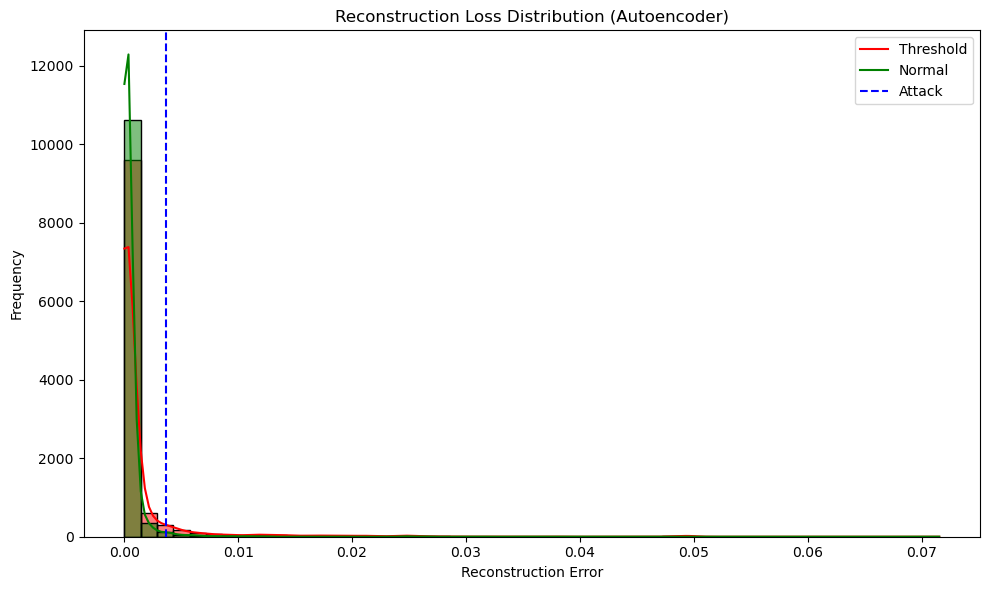

In [2]:
##Visualize Reconstruction Loss Distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame of losses and true labels
loss_df = pd.DataFrame()
loss_df["Reconstruction_error"] = mse
loss_df["True_label"] = y_true

# Plot
plt.figure(figsize=(10,6))
sns.histplot(data=loss_df, x="Reconstruction_error", hue="True_label", bins=50, kde=True, palette={0:'green', 1:'red'})
plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title("Reconstruction Loss Distribution (Autoencoder)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend(["Threshold", "Normal", "Attack"])
plt.tight_layout()
plt.show()

In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install xgboost


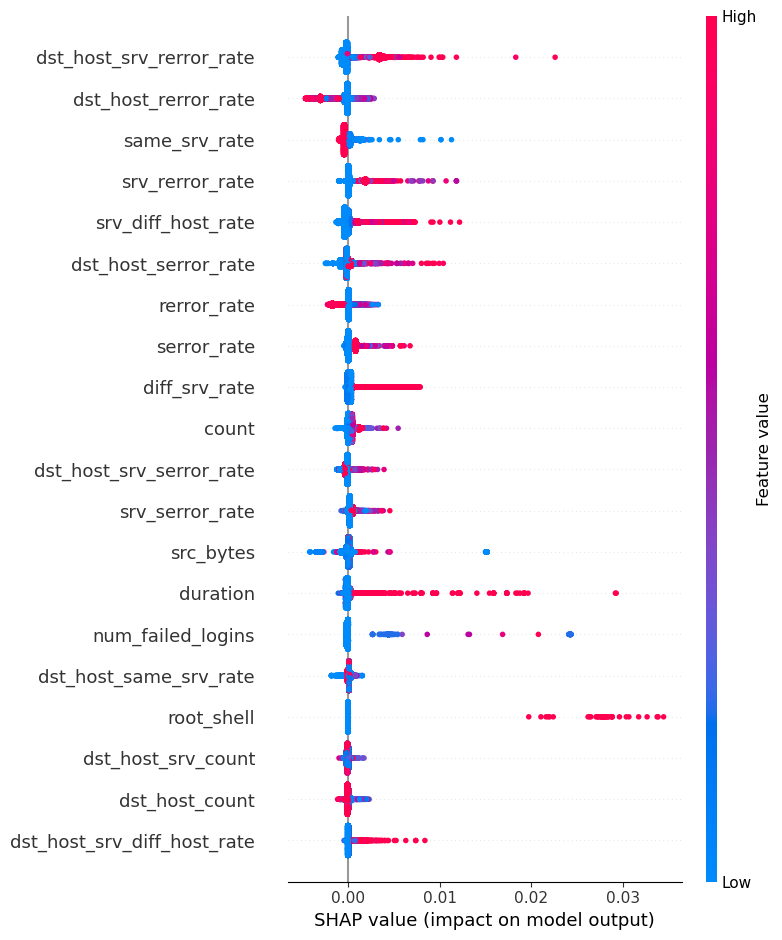

In [5]:
#SHAP Interpretability for Autoencoder
import shap
import xgboost as xgb

# Train a simple model on reconstruction error to approximate anomaly scoring
recon_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
recon_df["mse"] = mse

# Train regressor to predict mse
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_test_scaled, mse)

# SHAP explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_scaled)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)


In [6]:
# Example 1: if your label column is 'labels'
y_test = test_df['labels'].copy()

# OR Example 2: if your label column is 'attack_category'
# y_test = test_df['attack_category'].copy()


In [7]:
# Convert attack labels to binary (0 = normal, 1 = anomaly)
y_test = y_test.apply(lambda x: 0 if x == 'normal' else 1)


705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 156us/step


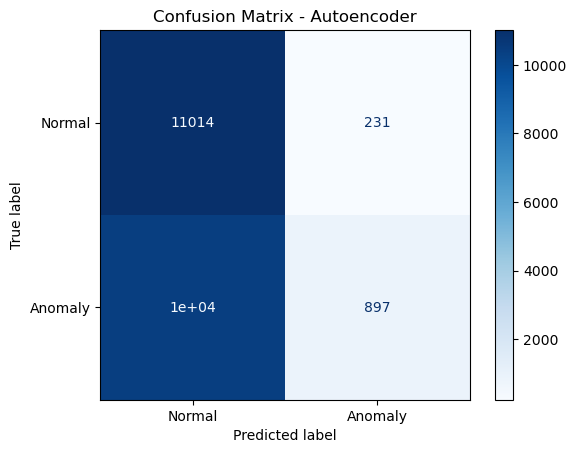

              precision    recall  f1-score   support

      Normal       0.51      0.98      0.67     11245
     Anomaly       0.80      0.08      0.14     11299

    accuracy                           0.53     22544
   macro avg       0.65      0.53      0.41     22544
weighted avg       0.66      0.53      0.41     22544



In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

X_test_pred = autoencoder.predict(X_test_scaled)
reconstruction_error = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)
threshold = np.percentile(reconstruction_error, 95)

y_pred = (reconstruction_error > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Autoencoder")
plt.show()

print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))


In [9]:
##Isolation Forest 

In [10]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Load data
train_df = pd.read_csv("kdd_train.csv")
test_df = pd.read_csv("kdd_test.csv")

In [12]:
# Combine for consistent encoding
combined_df = pd.concat([train_df, test_df], axis=0)

In [13]:
# Encode categorical columns
for col in combined_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col])

In [14]:
# Split back to train and test
train_df_encoded = combined_df.iloc[:len(train_df)]
test_df_encoded = combined_df.iloc[len(train_df):]

In [15]:
# Select features (drop label column if present)
X_train = train_df_encoded.drop(columns=['label'], errors='ignore')
X_test = test_df_encoded.drop(columns=['label'], errors='ignore')

In [16]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train_scaled)

IsolationForest(contamination=0.1, random_state=42)

In [18]:
# Predict (-1 = anomaly, 1 = normal)
y_pred = iso_forest.predict(X_test_scaled)
y_pred = [1 if p == -1 else 0 for p in y_pred]  # Convert: 1 = anomaly, 0 = normal


In [19]:
# Get true labels
y_true = test_df['labels'].apply(lambda x: 1 if x != 'normal' else 0)


In [20]:
# Evaluation
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred))

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.96      0.70     11245
           1       0.83      0.21      0.34     11299

    accuracy                           0.58     22544
   macro avg       0.69      0.58      0.52     22544
weighted avg       0.69      0.58      0.52     22544



Confusion Matrix:


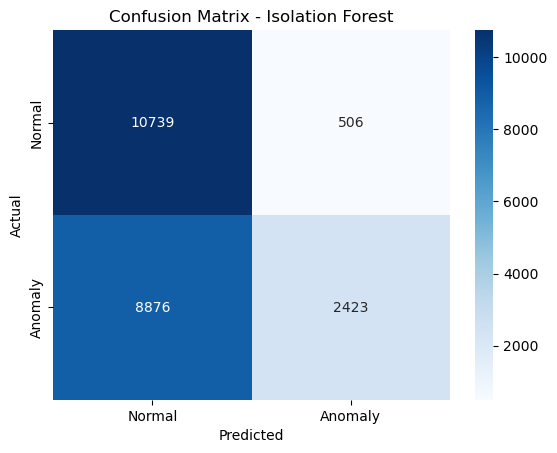

In [21]:
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Isolation Forest')
plt.show()

In [22]:
#visualize anomaly score distribution 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train)

IsolationForest(contamination=0.05, random_state=42)

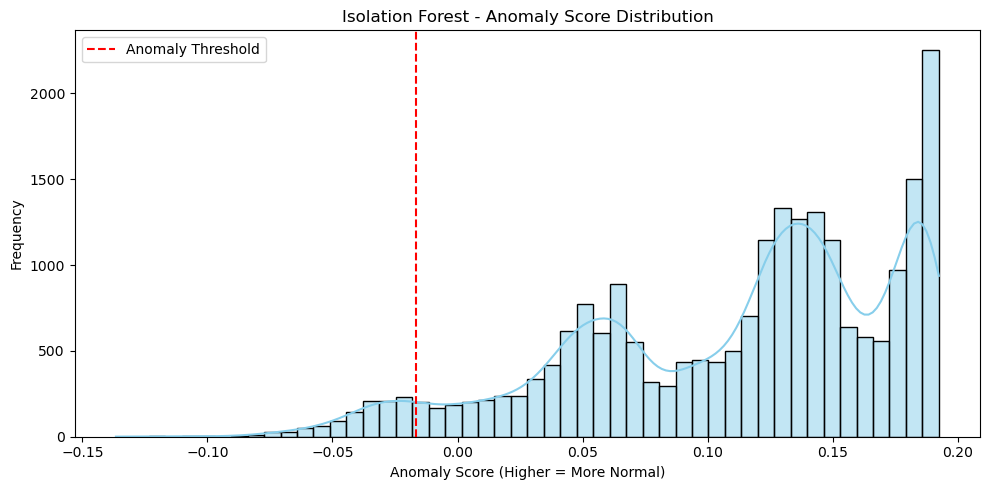

In [23]:
# Get anomaly scores (the lower, the more anomalous)
anomaly_scores = iso_forest.decision_function(X_test)  # Higher = more normal
predictions = iso_forest.predict(X_test)  # -1 = anomaly, 1 = normal

# Plot the distribution of anomaly scores
plt.figure(figsize=(10, 5))
sns.histplot(anomaly_scores, kde=True, bins=50, color="skyblue")
plt.axvline(x=np.percentile(anomaly_scores, 5), color='red', linestyle='--', label='Anomaly Threshold')
plt.title("Isolation Forest - Anomaly Score Distribution")
plt.xlabel("Anomaly Score (Higher = More Normal)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
#To apply SHAP interpretability to Isolation Forest, we need to train a surrogate model, since Isolation Forest is not natively supported by SHAP.
# Approach:
#Train Isolation Forest.

#Get its anomaly predictions (labels).

#Train a surrogate XGBoostClassifier on the same input and Isolation Forest's labels.

#Use SHAP to explain the surrogate model.

In [25]:
#SHAP Interpretability for Isolation Forest

In [26]:
import shap
import xgboost as xgb
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split


In [27]:
# 1. Train Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train)

IsolationForest(contamination=0.05, random_state=42)

In [28]:
# 2. Get anomaly labels from Isolation Forest
y_iforest_pred = iso_forest.predict(X_train)  # 1 = normal, -1 = anomaly
y_iforest_pred = (y_iforest_pred == -1).astype(int)  # Convert to binary: 1 = anomaly

In [29]:
# 3. Train a surrogate XGBoost model on the same input and Isolation Forest's labels
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_iforest_pred)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:22:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

 99%|===================| 125094/125973 [02:13<00:00]        

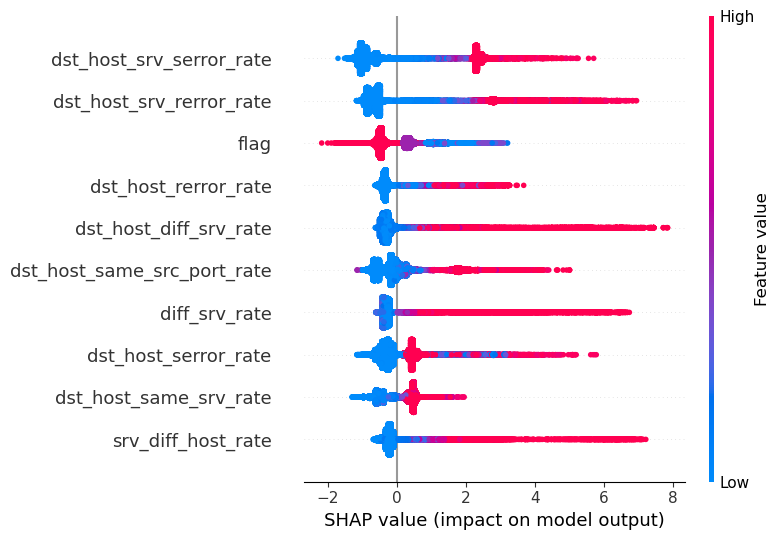

In [30]:
# 4. SHAP Explainer
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

# 5. Visualize SHAP summary plot
shap.summary_plot(shap_values, X_train, max_display=10)

In [31]:
#Random Forest

In [32]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


In [33]:
# Load datasets
train_df = pd.read_csv("kdd_train.csv")
test_df = pd.read_csv("kdd_test.csv")

In [34]:
# Define attack categories
attack_map = {
    'normal': 'normal',
    'neptune': 'DoS', 'smurf': 'DoS', 'back': 'DoS', 'teardrop': 'DoS',
    'pod': 'DoS', 'land': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS',
    'udpstorm': 'DoS', 'processtable': 'DoS',
    
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'mscan': 'Probe', 'saint': 'Probe',
    
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L',
    'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L',
    'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L',
    'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
    'sqlattack': 'U2R', 'xterm': 'U2R', 'ps': 'U2R'
}

In [35]:
#inspecting column names
print(train_df.columns)
print(test_df.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'labels'],
      dtype='object')
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_faile

In [36]:
# Label attack category
train_df['attack_category'] = train_df['labels'].map(attack_map)
test_df['attack_category'] = test_df['labels'].map(attack_map)


In [37]:
# Drop rows with NaN attack mapping
train_df = train_df.dropna(subset=['attack_category'])
test_df = test_df.dropna(subset=['attack_category'])

In [38]:
# Encode categorical columns
cat_cols = ['protocol_type', 'service', 'flag']
for col in cat_cols:
    enc = LabelEncoder()
    train_df[col] = enc.fit_transform(train_df[col])
    test_df[col] = enc.transform(test_df[col])

In [39]:
# Drop label columns
X_train = train_df.drop(columns=['labels', 'attack_category'])
X_test = test_df.drop(columns=['labels', 'attack_category'])

In [40]:
# Target for supervised models
y_train = train_df['attack_category']
y_test = test_df['attack_category']

# Normalize
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
#SMOTE (Synthetic Minority Oversampling Technique)
#Creates synthetic samples for minority classes.
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [42]:
#Class Weighting
#Tell the model to give more importance to rare classes.
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)


Classification Report:
               precision    recall  f1-score   support

         DoS       0.99      0.95      0.97      8095
       Probe       0.96      0.87      0.91      2157
         R2L       1.00      0.12      0.22      1009
         U2R       1.00      0.32      0.48        38
      normal       0.88      0.99      0.93     11245

    accuracy                           0.92     22544
   macro avg       0.97      0.65      0.70     22544
weighted avg       0.93      0.92      0.91     22544



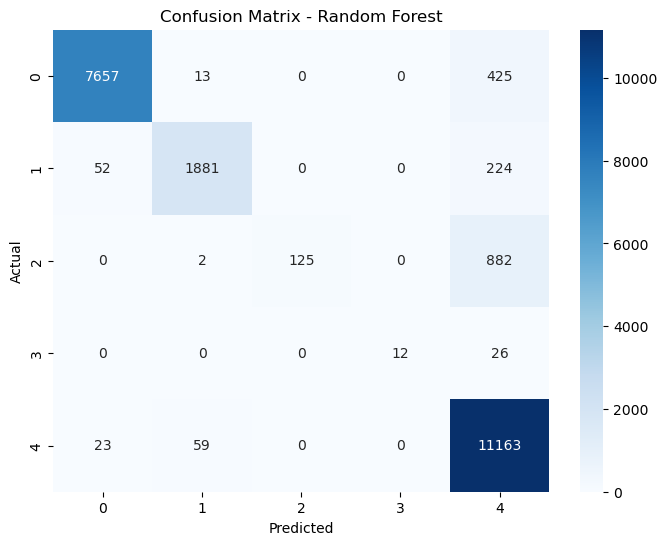

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [44]:
##Permutation Importance (Random Forest)
##This approach shuffles each feature and measures the drop in model performance.
##Features causing a larger drop are more important to the model.

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [46]:
# Load your dataset
train_df = pd.read_csv("kdd_train.csv")

# Separate features and target
X = train_df.drop(columns=["labels"])
y = train_df["labels"]

In [47]:
# Encode categorical features
label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

# Encode labels if they're also strings
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


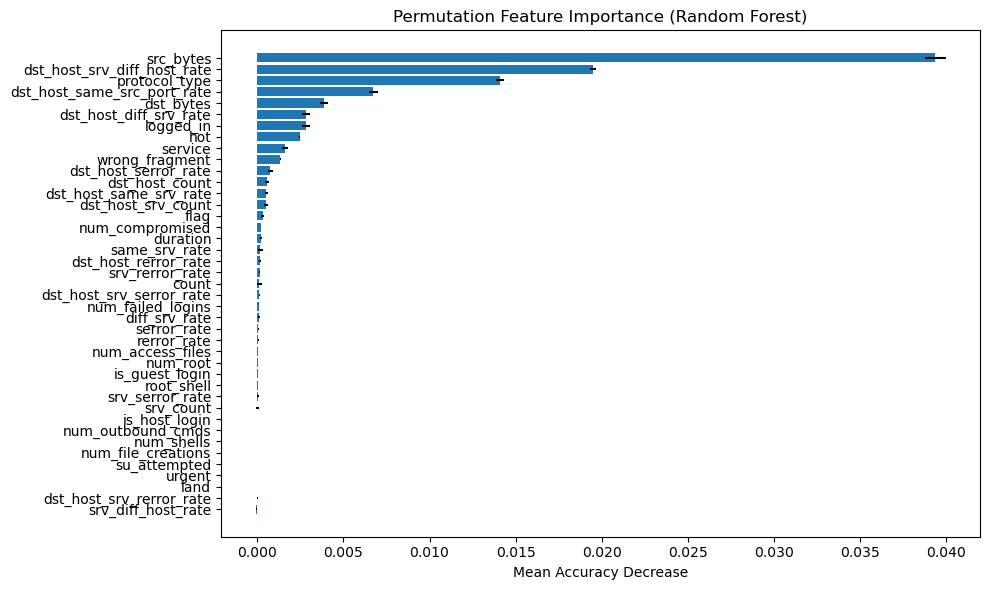

In [48]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Permutation importance
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# Visualize
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance_Mean'], xerr=importance_df['Importance_Std'])
plt.xlabel("Mean Accuracy Decrease")
plt.title("Permutation Feature Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [49]:
#Logistic Regression

In [50]:
import pandas as pd

train_df = pd.read_csv("kdd_train.csv")
test_df = pd.read_csv("kdd_test.csv")

print("Train columns:\n", train_df.columns.tolist())
print("\nTest columns:\n", test_df.columns.tolist())


Train columns:
 ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'labels']

Test columns:
 ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creati

In [51]:
# Replace 'label' with your actual label column name
X_train = train_encoded.drop(columns=['labels'])
X_test = test_encoded.drop(columns=['labels'])

# Convert label column to binary: 0 = normal, 1 = attack
y_train = train_encoded['labels'].apply(lambda x: 0 if label_encoders['labels'].inverse_transform([x])[0] == 'normal' else 1)
y_test = test_encoded['labels'].apply(lambda x: 0 if label_encoders['labels'].inverse_transform([x])[0] == 'normal' else 1)


NameError: name 'train_encoded' is not defined

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.77      0.92      0.84     11245
           1       0.90      0.73      0.81     11299

    accuracy                           0.83     22544
   macro avg       0.84      0.83      0.82     22544
weighted avg       0.84      0.83      0.82     22544



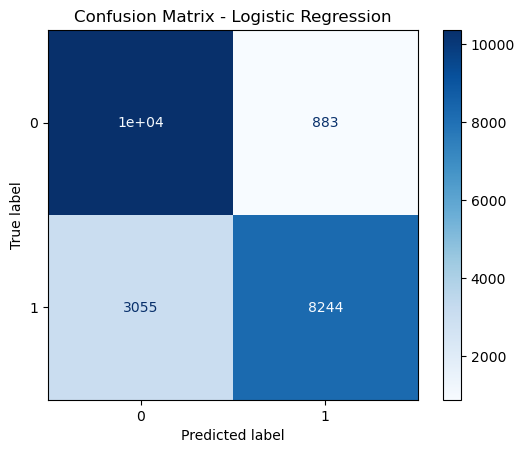

In [54]:
# Predict on test set
y_pred = lr_model.predict(X_test)

# Print classification report
print("Classification Report - Logistic Regression")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


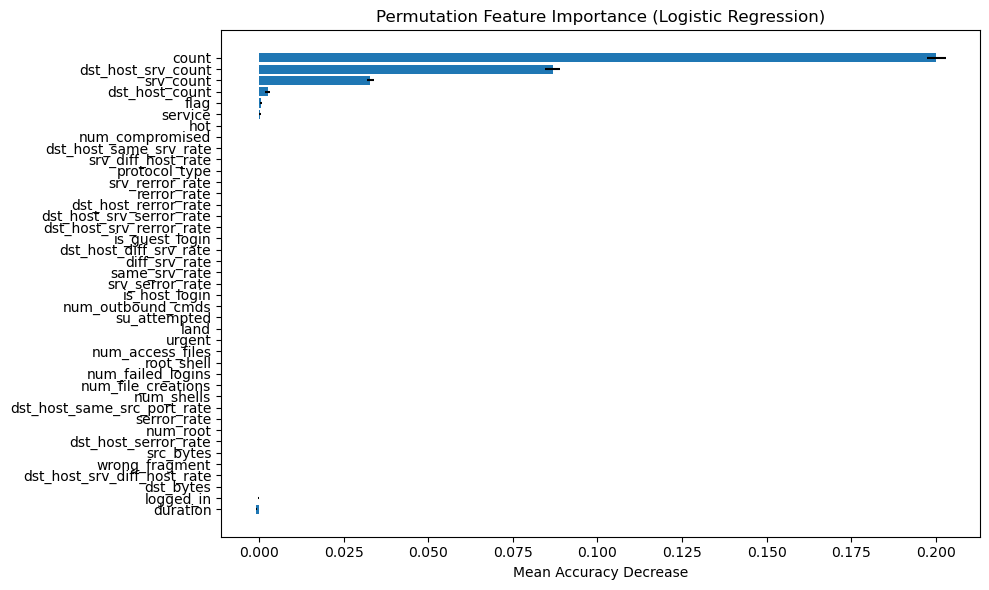

In [55]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Calculate permutation importance
perm_result = permutation_importance(
    lr_model, X_test, y_test, n_repeats=10, random_state=42
)

# Create DataFrame of importance
importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance_Mean": perm_result.importances_mean,
    "Importance_Std": perm_result.importances_std
}).sort_values(by="Importance_Mean", ascending=False)

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance_Mean"],
         xerr=importance_df["Importance_Std"])
plt.xlabel("Mean Accuracy Decrease")
plt.title("Permutation Feature Importance (Logistic Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
#Model Performance Comparison Code 

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [109]:
# Step 1: Encode your true labels (assuming your test labels are in `test_labels`)
le = LabelEncoder()
y_true_encoded = le.fit_transform(test_labels)  # test_labels should be the original ground truth


In [110]:
# Define dictionary to collect results
model_metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}


In [111]:
# Ground truth
y_true = [0 if lbl == 'normal' else 1 for lbl in test_labels]

In [112]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)  # use appropriate training set

# Predict on test set
log_pred = log_model.predict(X_test_scaled)


In [113]:
for key, value in model_metrics.items():
    print(f"{key}: {len(value)}")


Model: 0
Accuracy: 0
Precision: 0
Recall: 0
F1 Score: 0


In [119]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Random Forest
model_metrics["Model"].append("Random Forest")
model_metrics["Accuracy"].append(accuracy_score(y_test, rf_pred))
model_metrics["Precision"].append(precision_score(y_test, rf_pred, average='weighted'))
model_metrics["Recall"].append(recall_score(y_test, rf_pred, average='weighted'))
model_metrics["F1 Score"].append(f1_score(y_test, rf_pred, average='weighted'))

# Logistic Regression
model_metrics["Model"].append("Logistic Regression")
model_metrics["Accuracy"].append(accuracy_score(y_test, log_pred))
model_metrics["Precision"].append(precision_score(y_test, log_pred, average='weighted'))
model_metrics["Recall"].append(recall_score(y_test, log_pred, average='weighted'))
model_metrics["F1 Score"].append(f1_score(y_test, log_pred, average='weighted'))

# Isolation Forest
model_metrics["Model"].append("Isolation Forest")
model_metrics["Accuracy"].append(accuracy_score(y_test, iso_pred))
model_metrics["Precision"].append(precision_score(y_test, iso_pred, average='weighted'))
model_metrics["Recall"].append(recall_score(y_test, iso_pred, average='weighted'))
model_metrics["F1 Score"].append(f1_score(y_test, iso_pred, average='weighted'))

# Autoencoder
model_metrics["Model"].append("Autoencoder")
model_metrics["Accuracy"].append(accuracy_score(y_test, ae_pred))
model_metrics["Precision"].append(precision_score(y_test, ae_pred, average='weighted'))
model_metrics["Recall"].append(recall_score(y_test, ae_pred, average='weighted'))
model_metrics["F1 Score"].append(f1_score(y_test, ae_pred, average='weighted'))

# Results Table
results_df = pd.DataFrame(model_metrics)
print(results_df)


                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.000222   0.501198  0.000222  0.000443
1  Logistic Regression  0.892255   0.899081  0.892255  0.891811
2     Isolation Forest  0.834457   0.845985  0.834457  0.833111
3          Autoencoder  0.512021   0.569046  0.512021  0.388306


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


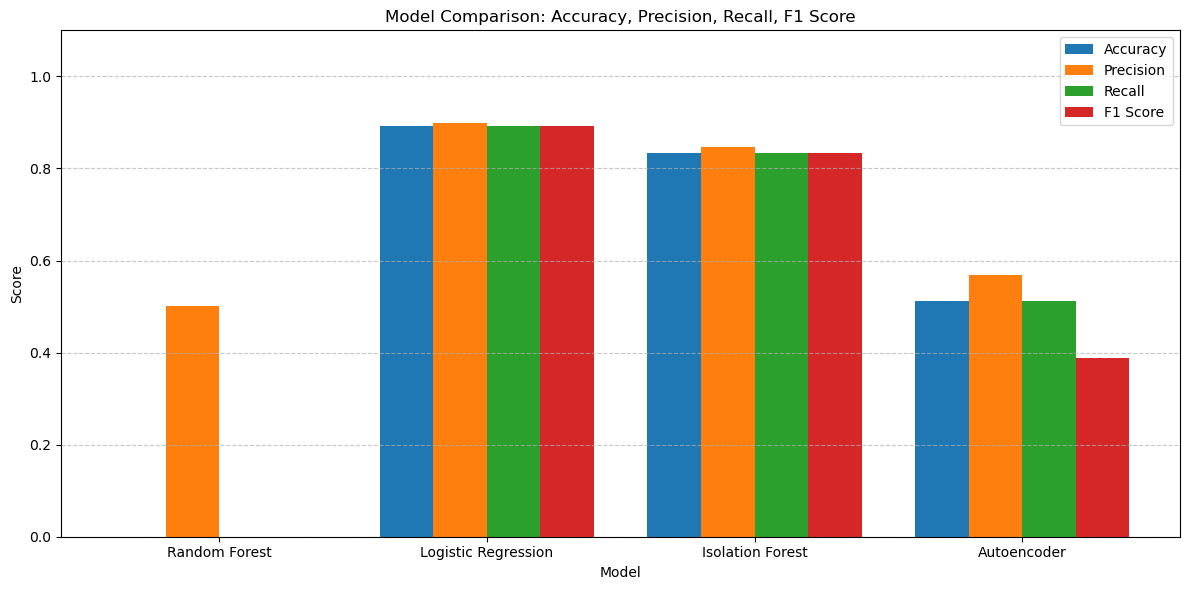

In [120]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12, 6))

# Set bar width and positions
bar_width = 0.2
index = range(len(results_df))

# Plotting each metric
plt.bar([i - 1.5 * bar_width for i in index], results_df['Accuracy'], width=bar_width, label='Accuracy')
plt.bar([i - 0.5 * bar_width for i in index], results_df['Precision'], width=bar_width, label='Precision')
plt.bar([i + 0.5 * bar_width for i in index], results_df['Recall'], width=bar_width, label='Recall')
plt.bar([i + 1.5 * bar_width for i in index], results_df['F1 Score'], width=bar_width, label='F1 Score')

# Labels and ticks
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy, Precision, Recall, F1 Score')
plt.xticks(index, results_df['Model'])
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
#Hybrid Model With logistic regression and Isolation forest

In [121]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [129]:
# Load data
train_df = pd.read_csv("kdd_train.csv")
test_df = pd.read_csv("kdd_test.csv")

In [130]:
# Combine train and test for uniform preprocessing
df = pd.concat([train_df, test_df])

In [131]:
# Encode categorical columns
cat_cols = ['protocol_type', 'service', 'flag']
df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

In [132]:
# Binary target: normal = 0, attack = 1
df['anomaly'] = df['labels'].apply(lambda x: 0 if x == 'normal' else 1)

In [133]:
# Drop original label column
df.drop(columns=['labels'], inplace=True)


In [134]:
# Separate features and target
X = df.drop(columns=['anomaly'])
y = df['anomaly']

In [135]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [136]:
# Step 1: Train Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(X_scaled)
iso_pred = iso.predict(X_scaled)

In [137]:
# Convert Isolation Forest prediction: 1 (inlier) => 0 (normal), -1 (outlier) => 1 (anomaly)
iso_pred = [0 if x == 1 else 1 for x in iso_pred]

In [138]:
# Step 2: Use Isolation Forest's predictions as features with Logistic Regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_scaled, iso_pred, test_size=0.3, random_state=42)


In [139]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_lr, y_train_lr)
y_pred_lr = lr.predict(X_test_lr)

In [140]:
# Results
print("🔍 Hybrid Model Evaluation (Isolation Forest + Logistic Regression)")
print(confusion_matrix(y_test_lr, y_pred_lr))
print(classification_report(y_test_lr, y_pred_lr, digits=4))


🔍 Hybrid Model Evaluation (Isolation Forest + Logistic Regression)
[[39828   366]
 [  865  3497]]
              precision    recall  f1-score   support

           0     0.9787    0.9909    0.9848     40194
           1     0.9053    0.8017    0.8503      4362

    accuracy                         0.9724     44556
   macro avg     0.9420    0.8963    0.9176     44556
weighted avg     0.9715    0.9724    0.9716     44556



In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for plotting
results_df = pd.DataFrame({
    'True Label': y_test_lr,
    'Predicted Label': y_pred_lr
})


In [142]:
# Count values for confusion matrix-style bar plot
counts = results_df.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Count')
counts['True Label'] = counts['True Label'].map({0: 'Normal', 1: 'Anomaly'})
counts['Predicted Label'] = counts['Predicted Label'].map({0: 'Normal', 1: 'Anomaly'})

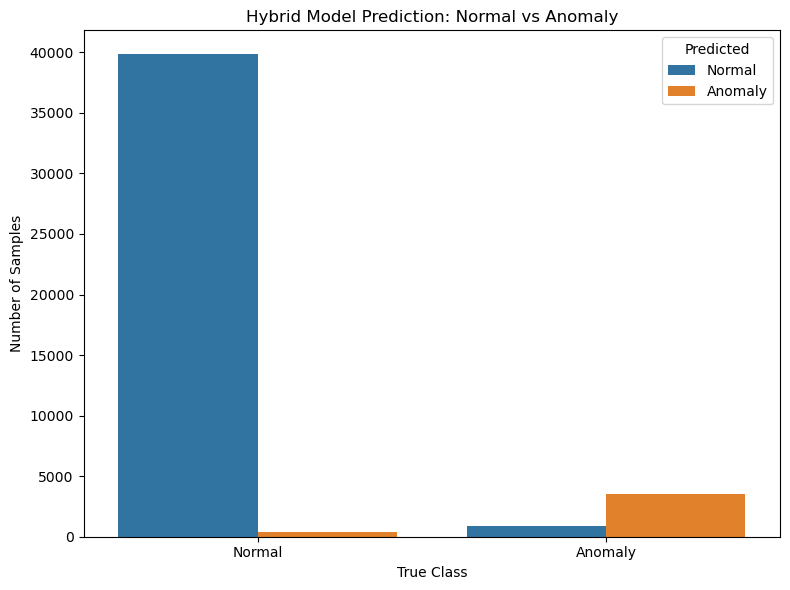

In [143]:
# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=counts, x='True Label', y='Count', hue='Predicted Label')
plt.title('Hybrid Model Prediction: Normal vs Anomaly')
plt.ylabel('Number of Samples')
plt.xlabel('True Class')
plt.legend(title='Predicted')
plt.tight_layout()
plt.show()

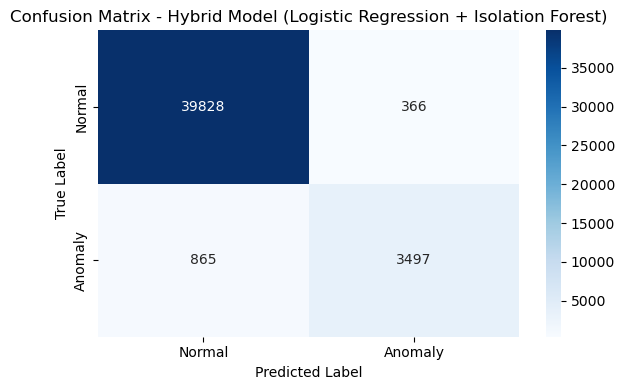

In [144]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)

# Define class names
labels = ['Normal', 'Anomaly']

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Hybrid Model (Logistic Regression + Isolation Forest)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
